# Source Detection

In [2]:
from karabo.imaging.imager import Imager
from karabo.simulation.telescope import Telescope
from karabo.simulation.observation import Observation
from karabo.simulation.interferometer import InterferometerSimulation
from karabo.simulation.sky_model import SkyModel
from karabo.sourcedetection.result import (
    SourceDetectionResult,
    PyBDSFSourceDetectionResult,
)
from karabo.sourcedetection.evaluation import SourceDetectionEvaluation

import matplotlib.pyplot as plt

# Render plots inline
%matplotlib inline

The RASCIL data directory is not available - continuing but any simulations will fail


## Simulation

/home/lukas/i4ds/ska/Karabo-Pipeline/karabo/simulation/sky_model.py:435: RuntimeWarning: invalid value encountered in log10
  flux = cfun(flux)


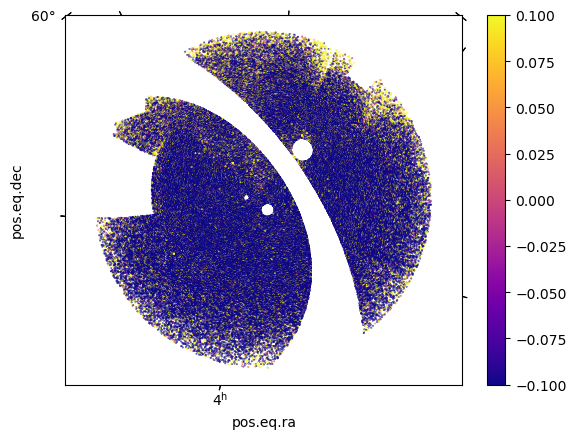

In [4]:
# Get GLEAM Survey Sky
phase_center = [250, -80]
gleam_sky = SkyModel.get_GLEAM_Sky()
gleam_sky.explore_sky(phase_center, s=0.1)

Then we filter the sky model based on radius.

In [5]:
sky = gleam_sky.filter_by_radius(0, 0.5, phase_center[0], phase_center[1])
sky.setup_default_wcs(phase_center=phase_center)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---AIR'  'DEC--AIR'  
CRVAL : 250.0  -80.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -1.0  1.0  
NAXIS : 0  0

Let's have a closer look with the 2d image project explore_sky() provides.

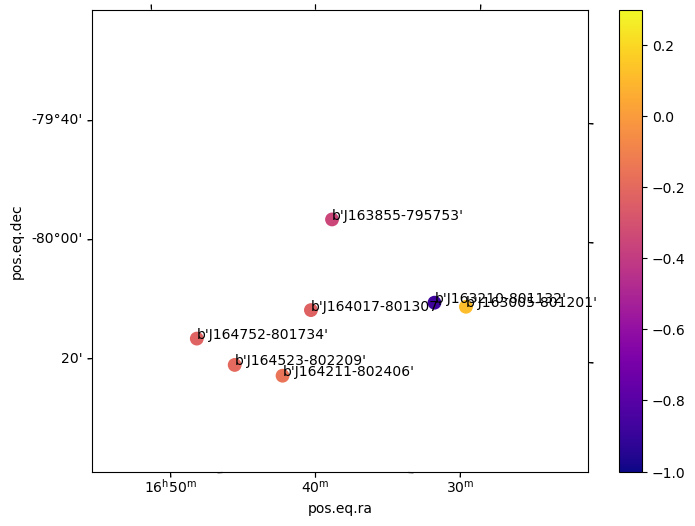

In [6]:
sky.explore_sky(
    phase_center=phase_center,
    figsize=(8, 6),
    xlim=(254, 246),  # RA-lim
    ylim=(-81, -79),  # DEC-lim
    with_labels=True,
    s=80,
    vmin=-1,
    vmax=0.3,
)

### Telescope Module

Various observation parameters and meta information `params` must be passed to the telescope module `oskar.Interferometer` of OSKAR as `oskar.SettingsTree`.

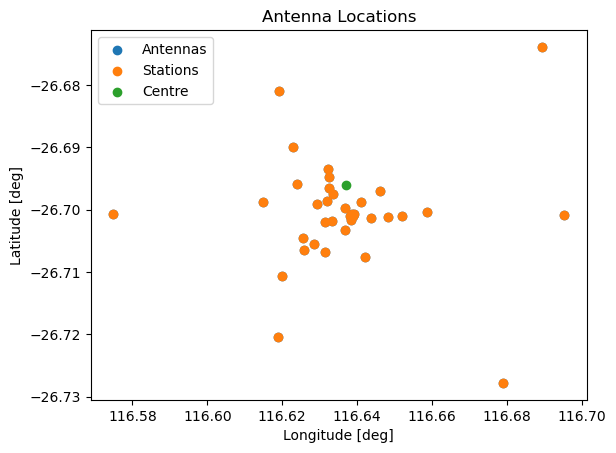

In [7]:
askap_tel = Telescope.get_ASKAP_Telescope()
askap_tel.plot_telescope()

### Observation Simulation

Now the sky module must be passed to the interferometer and the simulation of the observation must be started to generate the measurement set.

In [8]:
observation_settings = Observation(
    start_frequency_hz=100e6,
    phase_centre_ra_deg=phase_center[0],
    phase_centre_dec_deg=phase_center[1],
    number_of_channels=64,
    number_of_time_steps=24,
)

interferometer_sim = InterferometerSimulation(channel_bandwidth_hz=1e6)
visibility_askap = interferometer_sim.run_simulation(
    askap_tel, sky, observation_settings
)

No GPU is available
use_gpu is None, using is_cuda_available() to set use_gpu to False
No GPU is available


### Dirty Images

We can create dirty images of visibilites and display them as shown below

In [9]:
imaging_npixel = 2048
imaging_cellsize = 3.878509448876288e-05

WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'STOKES'  'FREQ'  
CRVAL : 250.0  -80.0  1.0  100000000.0  
CRPIX : 1025.0  1025.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.0022222222222222  0.0022222222222222  1.0  1.0  
NAXIS : 2048  2048  1  64


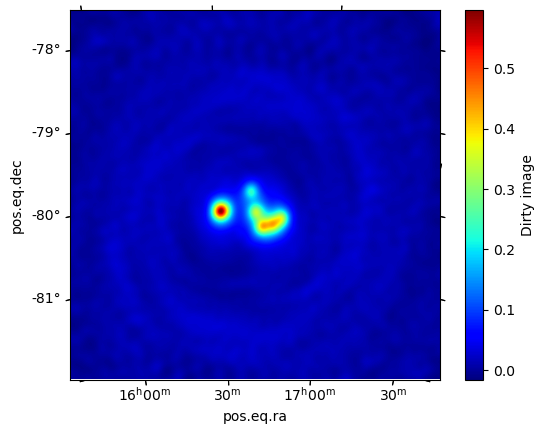

In [10]:
imager_askap = Imager(
    visibility_askap,
    imaging_npixel=imaging_npixel,
    imaging_cellsize=imaging_cellsize,
)
dirty = imager_askap.get_dirty_image()
dirty.plot(title="Dirty image")

### Source Detection

In [11]:
beam_guess = PyBDSFSourceDetectionResult.guess_beam_parameters(
    imager=imager_askap, method="rascil_1_iter"
)
detection_result_dirty = PyBDSFSourceDetectionResult.detect_sources_in_image(
    image=dirty, beam=beam_guess
)

--> Opened '/home/lukas/i4ds/ska/Karabo-Pipeline/karabo/examples/.tmp/52cb9520-8c25-4f3c-ba19-1b857c0f5e74'
Image size .............................. : (2048, 2048) pixels
Number of channels ...................... : 64
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (6.88308e-02, 6.33377e-02, 6.3) degrees
--> Channels averaged with uniform weights
--> Source extraction will be done on averaged ("ch0") image
Frequency of averaged image ............. : 100.000 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 62.178 Jy
--> Calculating background rms and mean images
Derived rms_box (box size, step size) ... : (2341, 205) pixels
--> Size of rms_box larger than 1/4 of image size
--> Using constant background rms and mean
Value of background rms ................. : 8.16e-03 Jy/beam
Value of background mean ................ : 0.00919 Jy/beam
--> Expected 5-sigma-clipped false detection rate < fdr_rati

Fitting islands with Gaussians .......... : [|] 0/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [] 1/1[-4G

stty: 'standard input': Inappropriate ioctl for device
Total number of Gaussians fit to image .. : 5
Total flux density in model ............. : 13.942 Jy


stty: 'standard input': Inappropriate ioctl for device
--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 4


--> Wrote ASCII file '/home/lukas/i4ds/ska/Karabo-Pipeline/karabo/examples/.tmp/4569c72b-dd66-4ff0-b6c2-c7fa45e21ffc'
--> Wrote file '/home/lukas/i4ds/ska/Karabo-Pipeline/karabo/examples/.tmp/46da721a-94db-496c-85ce-72f75540c5ef'


In [12]:
ground_truth, sky_idxs = Imager.project_sky_to_image(
    sky=sky,
    phase_center=phase_center,
    imaging_cellsize=imaging_cellsize,
    imaging_npixel=imaging_npixel,
    filter_outlier=True,
    invert_ra=True,
)

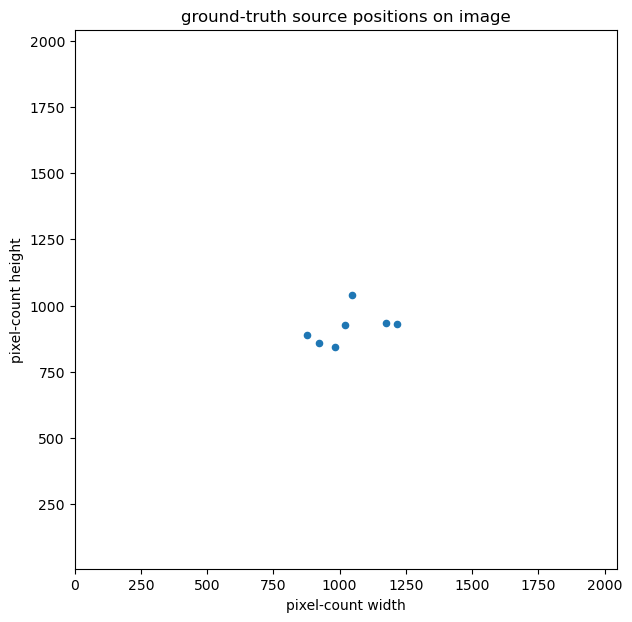

In [13]:
fig, ax = plt.subplots(
    figsize=(7, 7),
)
sc = ax.scatter(ground_truth[0], ground_truth[1], s=20)

# for idx, i in enumerate(range(ground_truth[0].shape[0])):
#     ax.annotate(sky[idx,-1], (ground_truth[0][i], ground_truth[1][i]))

plt.axis("equal")
plt.title("ground-truth source positions on image")
plt.xlim((0, imaging_npixel))
plt.ylim((0, imaging_npixel))
plt.xlabel("pixel-count width")
plt.ylabel("pixel-count height")
plt.show()

In [14]:
assignments_dirty = (
    SourceDetectionEvaluation.automatic_assignment_of_ground_truth_and_prediction(
        ground_truth=ground_truth.T,
        detected=detection_result_dirty.get_pixel_position_of_sources().T,
        max_dist=10,
        top_k=3,
    )
)
assignments_dirty

array([[-1.        ,  0.        ,         inf],
       [ 0.        ,  2.        ,  8.57481666],
       [ 1.        , -1.        ,         inf],
       [ 2.        , -1.        ,         inf],
       [ 3.        ,  3.        ,  3.58007624],
       [ 4.        ,  4.        ,  4.03425488],
       [ 5.        , -1.        ,         inf],
       [ 6.        ,  1.        ,  6.48946221]])

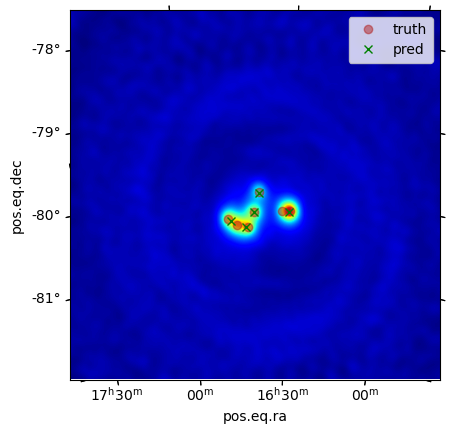

In [15]:
sde_dirty = SourceDetectionEvaluation(
    sky=sky,
    ground_truth=ground_truth,
    assignments=assignments_dirty,
    sky_idxs=sky_idxs,
    source_detection=detection_result_dirty,
)
sde_dirty.plot()

### Imaging
Of course, we can also do source detection on cleaned (clean algorithmus by rascil) images.

In [16]:
imager_askap.ingest_chan_per_blockvis = 1
imager_askap.ingest_vis_nchan = 16

# Try differnet algorithm
# More sources
deconvolved, restored, residual = imager_askap.imaging_rascil(
    clean_nmajor=0,
    clean_algorithm="mmclean",
    clean_scales=[0, 6, 10, 30, 60],
    clean_fractional_threshold=0.3,
    clean_threshold=0.12e-3,
    clean_nmoment=5,
    clean_psf_support=640,
    clean_restored_output="integrated",
)

## Analysis via Source Detection

Source Detection on restored image.

In [17]:
detection_result = PyBDSFSourceDetectionResult.detect_sources_in_image(restored)

--> Opened '/home/lukas/i4ds/ska/Karabo-Pipeline/karabo/examples/.tmp/9a3d5fe7-a70b-4bf0-b01e-d1700b2e8b74'
Image size .............................. : (2048, 2048) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (6.88308e-02, 6.33377e-02, 6.3) degrees
Frequency of image ...................... : 100.000 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 26.975 Jy
--> Calculating background rms and mean images
Derived rms_box (box size, step size) ... : (2451, 205) pixels
--> Size of rms_box larger than 1/4 of image size
--> Using constant background rms and mean
Value of background rms ................. : 2.89e-03 Jy/beam
Value of background mean ................ : 0.00346 Jy/beam
--> Expected 5-sigma-clipped false detection rate < fdr_ratio
--> Using sigma-clipping ('hard') thresholding
Minimum number of pixels per island ..... : 333
Number o

Fitting islands with Gaussians .......... : [|] 0/1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [] 1/1[-4G

stty: 'standard input': Inappropriate ioctl for device
Total number of Gaussians fit to image .. : 11
Total flux density in model ............. : 8.531 Jy


stty: 'standard input': Inappropriate ioctl for device
--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 4


--> Wrote ASCII file '/home/lukas/i4ds/ska/Karabo-Pipeline/karabo/examples/.tmp/abe63a39-bcd4-476e-8d2c-9d7167312360'
--> Wrote file '/home/lukas/i4ds/ska/Karabo-Pipeline/karabo/examples/.tmp/b1e805f8-6924-42a2-ba28-0c9f1da95462'


## Evaluation

In [18]:
assignments_restored = (
    SourceDetectionEvaluation.automatic_assignment_of_ground_truth_and_prediction(
        ground_truth=ground_truth.T,
        detected=detection_result.get_pixel_position_of_sources().T,
        max_dist=10,
        top_k=3,
    )
)
assignments_restored

array([[-1.        ,  0.        ,         inf],
       [-1.        ,  1.        ,         inf],
       [-1.        ,  4.        ,         inf],
       [-1.        ,  8.        ,         inf],
       [-1.        , 10.        ,         inf],
       [ 0.        ,  2.        ,  2.34492674],
       [ 1.        ,  5.        ,  1.9873448 ],
       [ 2.        ,  6.        ,  2.96580921],
       [ 3.        ,  9.        ,  0.9336145 ],
       [ 4.        ,  3.        ,  1.93481789],
       [ 5.        , -1.        ,         inf],
       [ 6.        ,  7.        ,  0.97878307]])

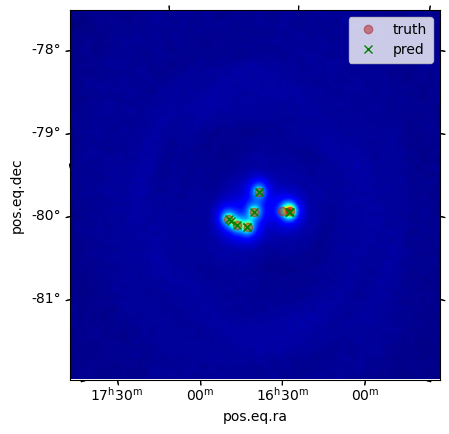

In [19]:
# Create mapping plots
sde_restored = SourceDetectionEvaluation(
    sky=sky,
    ground_truth=ground_truth,
    assignments=assignments_restored,
    sky_idxs=sky_idxs,
    source_detection=detection_result,
)
sde_restored.plot()

In [20]:
# Confusion Matrix
sde_restored.get_confusion_matrix()

array([[0., 5.],
       [1., 6.]])

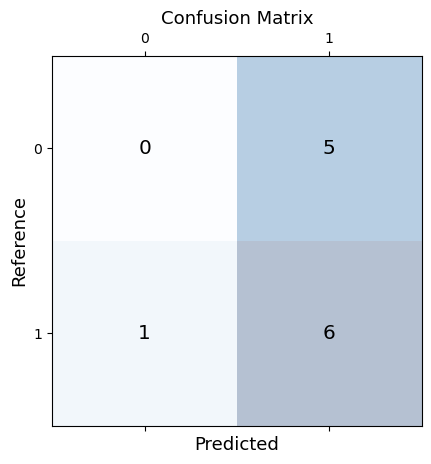

In [21]:
sde_restored.plot_confusion_matrix()

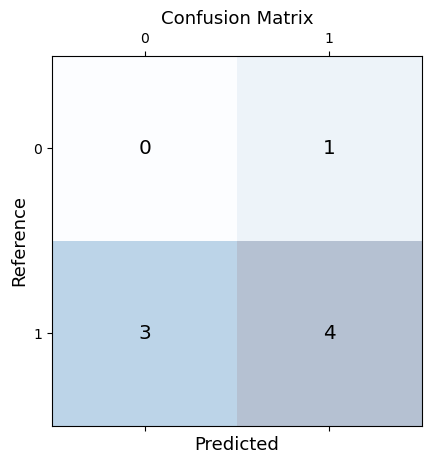

In [22]:
sde_dirty.plot_confusion_matrix()

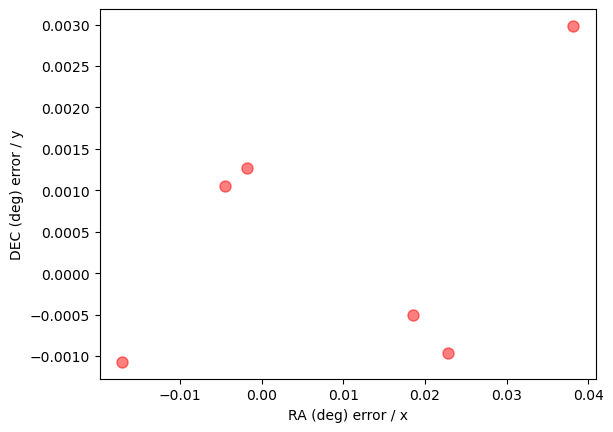

In [23]:
# Plot error ra and dec
sde_restored.plot_error_ra_dec()

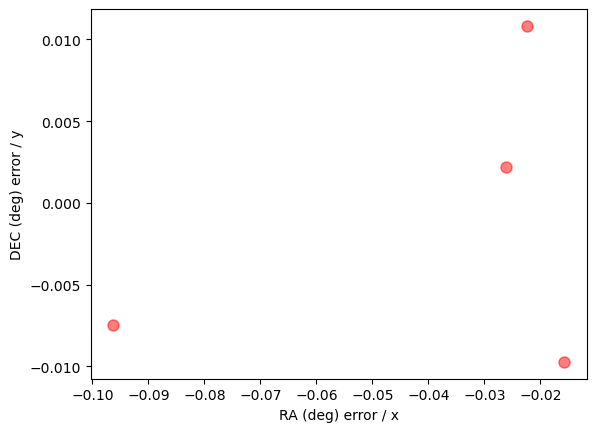

In [24]:
# Plot error ra and dec
sde_dirty.plot_error_ra_dec()

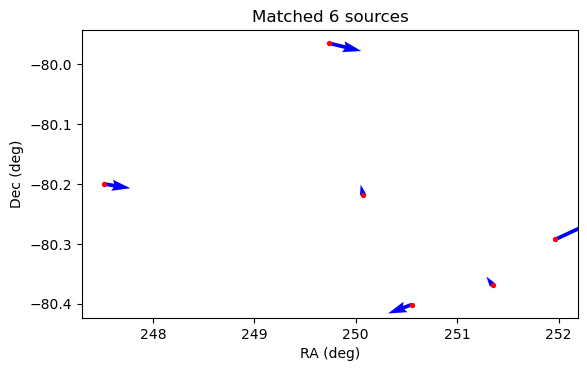

In [25]:
# Plot error flux
sde_restored.plot_quiver_positions()

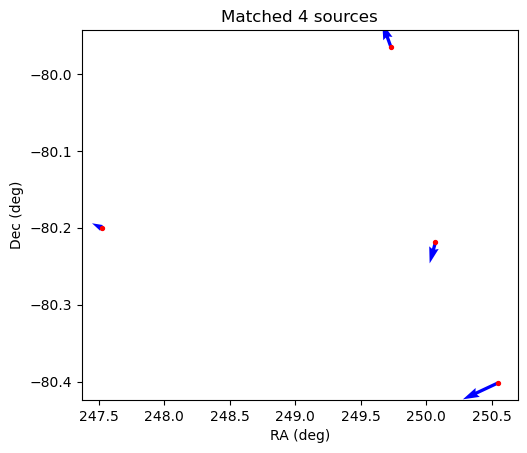

In [26]:
# Plot error flux
sde_dirty.plot_quiver_positions()

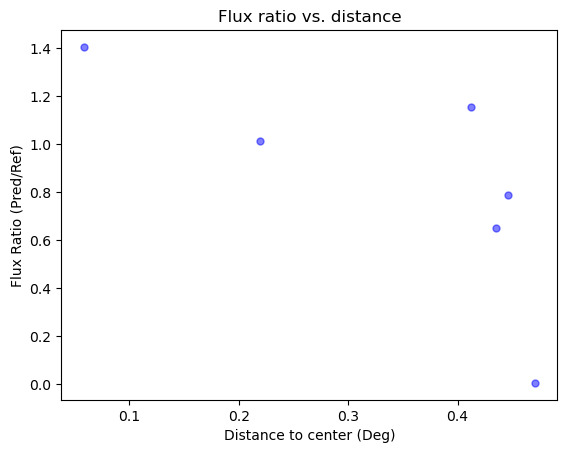

In [27]:
# Plot error ra and dec
sde_restored.plot_flux_ratio_to_distance()

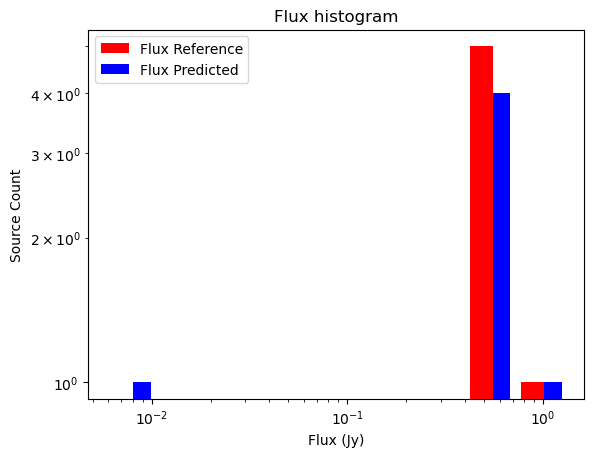

In [28]:
# Plot error ra and dec
sde_restored.plot_flux_histogram()

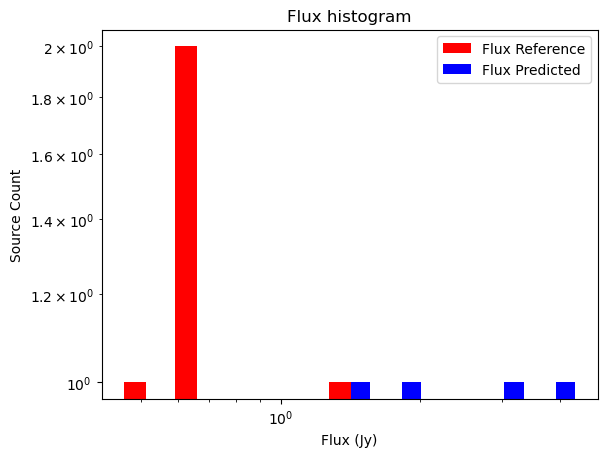

In [29]:
# Plot error ra and dec
sde_dirty.plot_flux_histogram()

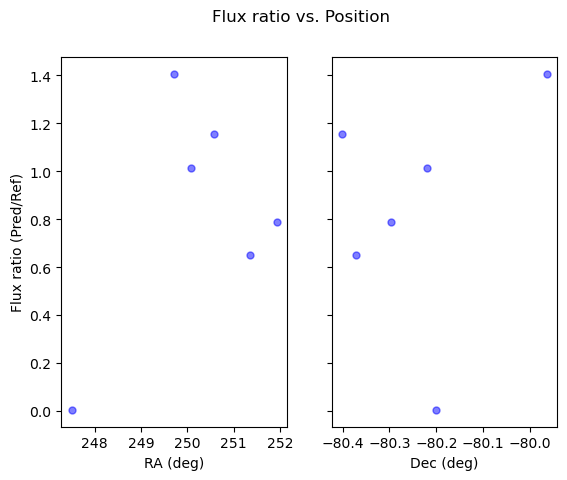

In [30]:
# Plot error ra and dec
sde_restored.plot_flux_ratio_to_ra_dec()

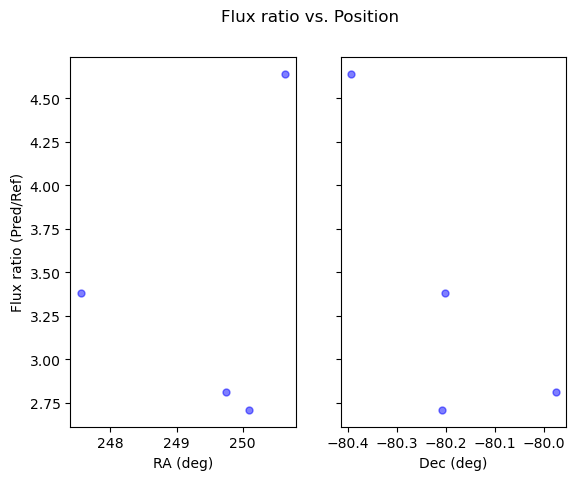

In [31]:
# Plot error ra and dec
sde_dirty.plot_flux_ratio_to_ra_dec()